# Object Detection Project 

In this jupyter notebook, you have to write your own detector network based on a simplified KITTI dataset for 2D object detection. We already provided an exemplary setup to the problem.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
from tqdm.notebook import tqdm
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.transform
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import os
import random
import argparse
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from math import sqrt
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import torchvision.transforms as T

##Mount your Google Drive

## Load data

In [ ]:
store_path = F"/content/drive/MyDrive/Perception_project_2021" #adapt to your file location
x_train = np.load(os.path.join(store_path, "x_train.npy"))
#x_test = np.load(os.path.join(store_path, "x_test.npy")) 
y_train = np.load(os.path.join(store_path, "y_train.npy"), allow_pickle=True)

In [ ]:
store_path = F"/content/drive/MyDrive/Perception_project_2021"
y_prediction_hing_irbeku = np.load(os.path.join(store_path, "pred_example.npy"), allow_pickle=True)
print(y_prediction_hing_irbeku)

[{'boxes': array([[ 91, 154, 142, 211],
       [ 90, 100, 142, 128]]), 'classes': array([0., 0.]), 'scores': array([1. , 0.7])}
 {'boxes': array([[ 87, 129, 112, 155],
       [ 90,  88, 101, 104],
       [ 88,  10, 110,  20],
       [ 88, 118,  97, 129]]), 'classes': array([0., 0., 0., 0.]), 'scores': array([0.9, 0.8, 0.7, 0.5])}]


## Plot example 
Here, we plot an example image and the corresponding GT bounding boxes.

5
[array([ 87.295, 129.31 , 112.37 , 155.215]), array([ 90.045,  87.795, 101.21 , 103.275]), array([ 87.775, 118.025,  96.895, 129.635])]
1
float32


TypeError: ignored

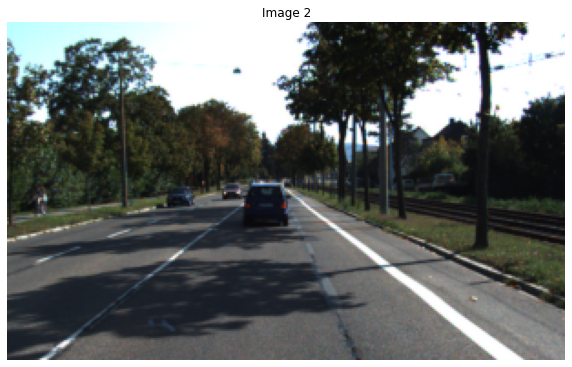

In [ ]:
# Colormap for plotted bounding boxes 
cmap = {0: "r", "Pedestrian": "g", "Cyclist": "b", "Van": "yellow", "Truck": "black"}
#we deleted labels other than cars
print(len(cmap))
# Get boxes & classes for specific image
im_number = 2
new_boxes = ()
boxes = y_train[im_number]["boxes"]
#print(boxes)

print(boxes)
#new_boxes = xy2yx(boxes=boxes)
#print(new_boxes)

classes = new_classes[im_number]
print(classes)
print(x_train.dtype)
# Plot image
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(x_train[im_number, ...])
ax.axis("off")
plt.title(f"Image {im_number}")

# Plot colored bounding boxes
for bbox, cls in zip(boxes, classes):
    try:
        cl = cmap[cls]
    except:
        cl = cmap['Misc']
    # Add rectangle (x,y), width, heigth
    height = bbox[2] - bbox[0]
    width = bbox[3] - bbox[1]
    rect = patches.Rectangle((bbox[1], bbox[0]), width, height, linewidth=1, edgecolor=cl, facecolor="none")
    ax.add_patch(rect)

In [ ]:
num_samples = 500
i = range(len(x_train))
random_index = random.sample(i, num_samples)
 

for j in range(len(y_train[random_index[i]]['boxes'])):
  print(y_train[random_index[i]]['boxes'][j][1])
      


In [ ]:
for i in range(len(y_train)):
  classes = y_train[i]["classes"]
  new_classes = []
  for j in classes:
    new_classes.append(j+1)
    print(new_classes)



# Functions needed to calc mAP
It is not necessary to understand them in detail, but nontheless it is important to understand the mAP score.

In [ ]:
import six
import itertools
from collections import defaultdict


def voc_eval(pred_bboxes, pred_labels, pred_scores, gt_bboxes, gt_labels,
             gt_difficults=None, iou_thresh=0.5, use_07_metric=True):
    '''Wrap VOC evaluation for PyTorch.'''
    pred_bboxes = [xy2yx(b).cpu().numpy() for b in pred_bboxes]
    pred_labels = [label.numpy() for label in pred_labels]
    pred_scores = [score.cpu().numpy() for score in pred_scores]
    gt_bboxes = [xy2yx(b).cpu().numpy() for b in gt_bboxes]
    gt_labels = [label.numpy() for label in gt_labels]
    return eval_detection_voc(
               pred_bboxes, pred_labels, pred_scores, gt_bboxes,
               gt_labels, gt_difficults, iou_thresh, use_07_metric)

def xy2yx(boxes):
    '''Convert box (xmin,ymin,xmax,ymax) to (ymin,xmin,ymax,xmax).'''
    c0 = boxes[:,0].clone()
    c2 = boxes[:,2].clone()
    boxes[:,0] = boxes[:,1]
    boxes[:,1] = c0
    boxes[:,2] = boxes[:,3]
    boxes[:,3] = c2
    return boxes

def bbox_iou(bbox_a, bbox_b):
    '''Calculate the Intersection of Unions (IoUs) between bounding boxes.
    Args:
        bbox_a (array): An array whose shape is :math:`(N, 4)`.
            :math:`N` is the number of bounding boxes.
            The dtype should be :obj:`numpy.float32`.
        bbox_b (array): An array similar to :obj:`bbox_a`,
            whose shape is :math:`(K, 4)`.
            The dtype should be :obj:`numpy.float32`.
    Returns:
        array:
        An array whose shape is :math:`(N, K)`. \
        An element at index :math:`(n, k)` contains IoUs between \
        :math:`n` th bounding box in :obj:`bbox_a` and :math:`k` th bounding \
        box in :obj:`bbox_b`.
    '''
    # top left
    tl = np.maximum(bbox_a[:, None, :2], bbox_b[:, :2])
    # bottom right
    br = np.minimum(bbox_a[:, None, 2:], bbox_b[:, 2:])

    area_i = np.prod(br - tl, axis=2) * (tl < br).all(axis=2)
    area_a = np.prod(bbox_a[:, 2:] - bbox_a[:, :2], axis=1)
    area_b = np.prod(bbox_b[:, 2:] - bbox_b[:, :2], axis=1)
    return area_i / (area_a[:, None] + area_b - area_i)

def eval_detection_voc(
        pred_bboxes, pred_labels, pred_scores, gt_bboxes, gt_labels,
        gt_difficults=None,
        iou_thresh=0.5, use_07_metric=False):
    """Calculate average precisions based on evaluation code of PASCAL VOC.
    This function evaluates predicted bounding boxes obtained from a dataset
    which has :math:`N` images by using average precision for each class.
    The code is based on the evaluation code used in PASCAL VOC Challenge.
    Args:
        pred_bboxes (iterable of numpy.ndarray): An iterable of :math:`N`
            sets of bounding boxes.
            Its index corresponds to an index for the base dataset.
            Each element of :obj:`pred_bboxes` is a set of coordinates
            of bounding boxes. This is an array whose shape is :math:`(R, 4)`,
            where :math:`R` corresponds
            to the number of bounding boxes, which may vary among boxes.
            The second axis corresponds to
            :math:`y_{min}, x_{min}, y_{max}, x_{max}` of a bounding box.
        pred_labels (iterable of numpy.ndarray): An iterable of labels.
            Similar to :obj:`pred_bboxes`, its index corresponds to an
            index for the base dataset. Its length is :math:`N`.
        pred_scores (iterable of numpy.ndarray): An iterable of confidence
            scores for predicted bounding boxes. Similar to :obj:`pred_bboxes`,
            its index corresponds to an index for the base dataset.
            Its length is :math:`N`.
        gt_bboxes (iterable of numpy.ndarray): An iterable of ground truth
            bounding boxes
            whose length is :math:`N`. An element of :obj:`gt_bboxes` is a
            bounding box whose shape is :math:`(R, 4)`. Note that the number of
            bounding boxes in each image does not need to be same as the number
            of corresponding predicted boxes.
        gt_labels (iterable of numpy.ndarray): An iterable of ground truth
            labels which are organized similarly to :obj:`gt_bboxes`.
        gt_difficults (iterable of numpy.ndarray): An iterable of boolean
            arrays which is organized similarly to :obj:`gt_bboxes`.
            This tells whether the
            corresponding ground truth bounding box is difficult or not.
            By default, this is :obj:`None`. In that case, this function
            considers all bounding boxes to be not difficult.
        iou_thresh (float): A prediction is correct if its Intersection over
            Union with the ground truth is above this value.
        use_07_metric (bool): Whether to use PASCAL VOC 2007 evaluation metric
            for calculating average precision. The default value is
            :obj:`False`.
    Returns:
        dict:
        The keys, value-types and the description of the values are listed
        below.
        * **ap** (*numpy.ndarray*): An array of average precisions. \
            The :math:`l`-th value corresponds to the average precision \
            for class :math:`l`. If class :math:`l` does not exist in \
            either :obj:`pred_labels` or :obj:`gt_labels`, the corresponding \
            value is set to :obj:`numpy.nan`.
        * **map** (*float*): The average of Average Precisions over classes.
    """

    prec, rec = calc_detection_voc_prec_rec(
        pred_bboxes, pred_labels, pred_scores,
        gt_bboxes, gt_labels, gt_difficults,
        iou_thresh=iou_thresh)

    ap = calc_detection_voc_ap(prec, rec, use_07_metric=use_07_metric)

    return {'ap': ap, 'map': np.nanmean(ap)}


def calc_detection_voc_prec_rec(
        pred_bboxes, pred_labels, pred_scores, gt_bboxes, gt_labels,
        gt_difficults=None,
        iou_thresh=0.5):
    """Calculate precision and recall based on evaluation code of PASCAL VOC.
    This function calculates precision and recall of
    predicted bounding boxes obtained from a dataset which has :math:`N`
    images.
    The code is based on the evaluation code used in PASCAL VOC Challenge.
    Args:
        pred_bboxes (iterable of numpy.ndarray): An iterable of :math:`N`
            sets of bounding boxes.
            Its index corresponds to an index for the base dataset.
            Each element of :obj:`pred_bboxes` is a set of coordinates
            of bounding boxes. This is an array whose shape is :math:`(R, 4)`,
            where :math:`R` corresponds
            to the number of bounding boxes, which may vary among boxes.
            The second axis corresponds to
            :math:`y_{min}, x_{min}, y_{max}, x_{max}` of a bounding box.
        pred_labels (iterable of numpy.ndarray): An iterable of labels.
            Similar to :obj:`pred_bboxes`, its index corresponds to an
            index for the base dataset. Its length is :math:`N`.
        pred_scores (iterable of numpy.ndarray): An iterable of confidence
            scores for predicted bounding boxes. Similar to :obj:`pred_bboxes`,
            its index corresponds to an index for the base dataset.
            Its length is :math:`N`.
        gt_bboxes (iterable of numpy.ndarray): An iterable of ground truth
            bounding boxes
            whose length is :math:`N`. An element of :obj:`gt_bboxes` is a
            bounding box whose shape is :math:`(R, 4)`. Note that the number of
            bounding boxes in each image does not need to be same as the number
            of corresponding predicted boxes.
        gt_labels (iterable of numpy.ndarray): An iterable of ground truth
            labels which are organized similarly to :obj:`gt_bboxes`.
        gt_difficults (iterable of numpy.ndarray): An iterable of boolean
            arrays which is organized similarly to :obj:`gt_bboxes`.
            This tells whether the
            corresponding ground truth bounding box is difficult or not.
            By default, this is :obj:`None`. In that case, this function
            considers all bounding boxes to be not difficult.
        iou_thresh (float): A prediction is correct if its Intersection over
            Union with the ground truth is above this value..
    Returns:
        tuple of two lists:
        This function returns two lists: :obj:`prec` and :obj:`rec`.
        * :obj:`prec`: A list of arrays. :obj:`prec[l]` is precision \
            for class :math:`l`. If class :math:`l` does not exist in \
            either :obj:`pred_labels` or :obj:`gt_labels`, :obj:`prec[l]` is \
            set to :obj:`None`.
        * :obj:`rec`: A list of arrays. :obj:`rec[l]` is recall \
            for class :math:`l`. If class :math:`l` that is not marked as \
            difficult does not exist in \
            :obj:`gt_labels`, :obj:`rec[l]` is \
            set to :obj:`None`.
    """

    pred_bboxes = iter(pred_bboxes)
    pred_labels = iter(pred_labels)
    pred_scores = iter(pred_scores)
    gt_bboxes = iter(gt_bboxes)
    gt_labels = iter(gt_labels)
    if gt_difficults is None:
        gt_difficults = itertools.repeat(None)
    else:
        gt_difficults = iter(gt_difficults)

    n_pos = defaultdict(int)
    score = defaultdict(list)
    match = defaultdict(list)

    for pred_bbox, pred_label, pred_score, gt_bbox, gt_label, gt_difficult in \
        six.moves.zip(
            pred_bboxes, pred_labels, pred_scores,
            gt_bboxes, gt_labels, gt_difficults):

        if gt_difficult is None:
            gt_difficult = np.zeros(gt_bbox.shape[0], dtype=bool)

        for l in np.unique(np.concatenate((pred_label, gt_label)).astype(int)):
            pred_mask_l = pred_label == l
            pred_bbox_l = pred_bbox[pred_mask_l]
            pred_score_l = pred_score[pred_mask_l]
            # sort by score
            order = pred_score_l.argsort()[::-1]
            pred_bbox_l = pred_bbox_l[order]
            pred_score_l = pred_score_l[order]

            gt_mask_l = gt_label == l
            gt_bbox_l = gt_bbox[gt_mask_l]
            gt_difficult_l = gt_difficult[gt_mask_l]

            n_pos[l] += np.logical_not(gt_difficult_l).sum()
            score[l].extend(pred_score_l)

            if len(pred_bbox_l) == 0:
                continue
            if len(gt_bbox_l) == 0:
                match[l].extend((0,) * pred_bbox_l.shape[0])
                continue

            # VOC evaluation follows integer typed bounding boxes.
            pred_bbox_l = pred_bbox_l.copy()
            pred_bbox_l[:, 2:] += 1
            gt_bbox_l = gt_bbox_l.copy()
            gt_bbox_l[:, 2:] += 1

            iou = bbox_iou(pred_bbox_l, gt_bbox_l)
            gt_index = iou.argmax(axis=1)
            # set -1 if there is no matching ground truth
            gt_index[iou.max(axis=1) < iou_thresh] = -1
            del iou

            selec = np.zeros(gt_bbox_l.shape[0], dtype=bool)
            for gt_idx in gt_index:
                if gt_idx >= 0:
                    if gt_difficult_l[gt_idx]:
                        match[l].append(-1)
                    else:
                        if not selec[gt_idx]:
                            match[l].append(1)
                        else:
                            match[l].append(0)
                    selec[gt_idx] = True
                else:
                    match[l].append(0)

    for iter_ in (
            pred_bboxes, pred_labels, pred_scores,
            gt_bboxes, gt_labels, gt_difficults):
        if next(iter_, None) is not None:
            raise ValueError('Length of input iterables need to be same.')

    n_fg_class = max(n_pos.keys()) + 1
    prec = [None] * n_fg_class
    rec = [None] * n_fg_class

    for l in n_pos.keys():
        score_l = np.array(score[l])
        match_l = np.array(match[l], dtype=np.int8)

        order = score_l.argsort()[::-1]
        match_l = match_l[order]

        tp = np.cumsum(match_l == 1)
        fp = np.cumsum(match_l == 0)

        # If an element of fp + tp is 0,
        # the corresponding element of prec[l] is nan.
        prec[l] = tp / (fp + tp)
        # If n_pos[l] is 0, rec[l] is None.
        if n_pos[l] > 0:
            rec[l] = tp / n_pos[l]

    return prec, rec


def calc_detection_voc_ap(prec, rec, use_07_metric=False):
    """Calculate average precisions based on evaluation code of PASCAL VOC.
    This function calculates average precisions
    from given precisions and recalls.
    The code is based on the evaluation code used in PASCAL VOC Challenge.
    Args:
        prec (list of numpy.array): A list of arrays.
            :obj:`prec[l]` indicates precision for class :math:`l`.
            If :obj:`prec[l]` is :obj:`None`, this function returns
            :obj:`numpy.nan` for class :math:`l`.
        rec (list of numpy.array): A list of arrays.
            :obj:`rec[l]` indicates recall for class :math:`l`.
            If :obj:`rec[l]` is :obj:`None`, this function returns
            :obj:`numpy.nan` for class :math:`l`.
        use_07_metric (bool): Whether to use PASCAL VOC 2007 evaluation metric
            for calculating average precision. The default value is
            :obj:`False`.
    Returns:
        ~numpy.ndarray:
        This function returns an array of average precisions.
        The :math:`l`-th value corresponds to the average precision
        for class :math:`l`. If :obj:`prec[l]` or :obj:`rec[l]` is
        :obj:`None`, the corresponding value is set to :obj:`numpy.nan`.
    """

    n_fg_class = len(prec)
    ap = np.empty(n_fg_class)
    for l in six.moves.range(n_fg_class):
        if prec[l] is None or rec[l] is None:
            ap[l] = np.nan
            continue

        if use_07_metric:
            # 11 point metric
            ap[l] = 0
            for t in np.arange(0., 1.1, 0.1):
                if np.sum(rec[l] >= t) == 0:
                    p = 0
                else:
                    p = np.max(np.nan_to_num(prec[l])[rec[l] >= t])
                ap[l] += p / 11
        else:
            # correct AP calculation
            # first append sentinel values at the end
            mpre = np.concatenate(([0], np.nan_to_num(prec[l]), [0]))
            mrec = np.concatenate(([0], rec[l], [1]))

            mpre = np.maximum.accumulate(mpre[::-1])[::-1]

            # to calculate area under PR curve, look for points
            # where X axis (recall) changes value
            i = np.where(mrec[1:] != mrec[:-1])[0]

            # and sum (\Delta recall) * prec
            ap[l] = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])

    return ap

# Exemplary mAP calculation
The example below shows you, how the mAP is calculated for (fake) predictions on the training set.
A similar calculation will be used to predict the mean average precision of your algorithm on the test set.
Please store your predictions containing three dictionaries for the boxes, labels and scores per test image (similar to "pred_example.npy").

In [ ]:
store_path = F"/content/drive/MyDrive/Perception_project_2021" #adapt to your file location

#read prediction
pred_test = np.load(os.path.join(store_path, "pred_example.npy"), allow_pickle=True)
pred_boxes = [torch.Tensor(x["boxes"]) for x in pred_test]  # List with n_test elements [n_boxes, 4]
pred_classes = [torch.Tensor(x["classes"]) for x in pred_test] # List with n_test elements [n_boxes]
pred_scores = [torch.Tensor(x["scores"]) for x in pred_test] # List with n_test elements [n_boxes]

#read gt
gt = np.load(os.path.join(store_path, "y_train.npy"), allow_pickle=True)
gt_boxes = [torch.Tensor(x["boxes"]) for x in gt[1:3]]  # List with n_test elements [n_boxes, 4]
gt_labels = [torch.Tensor(x["classes"]) for x in gt[1:3]] # List with n_test elements [n_boxes]

## Calc mAP
print("Calculating mAP")
meanAP = voc_eval(pred_boxes, pred_classes, pred_scores, gt_boxes, gt_labels)["map"]
print('Mean Average Precision of best network: %.5f' % (meanAP))

Calculating mAP
Mean Average Precision of best network: 0.90909


# Loading the data

In [ ]:
from sklearn.model_selection import train_test_split
training_data, validation_data, training_labels, validation_labels = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [ ]:
print('training_data_shape', training_data.shape)
print('training_labels_shape', training_labels.shape)
print('validatin_dataset_shape', validation_data.shape, validation_labels.shape)
print(len(training_data))

training_boxes = [torch.Tensor(x["boxes"]) for x in training_labels]
#illi bounding_box boundary coordinates it is list of lenght N
#y_train_boxes_tensor = torch.Tensor(y_train_boxes[0]) 
#y_train_boxes_tensor = xy_to_cxcy(y_train_boxes)
print("numbers of boxes", len(training_boxes))
print(training_boxes[50])
training_classes = [torch.Tensor(x["classes"]) for x in training_labels]
#illi classes store agidhe
print("numbers of classes", len(training_classes))

training_data_shape (2969, 185, 306, 3)
training_labels_shape (2969,)
validatin_dataset_shape (743, 185, 306, 3) (743,)
2969
numbers of boxes 2969
tensor([[ 85.8750,  99.0750, 101.7000, 116.9200],
        [ 81.1200,  63.8850,  99.6900,  87.5850],
        [ 91.8400,  36.3450, 111.6650,  67.5300],
        [ 94.0550,  -2.0450, 113.5850,  33.4800],
        [ 91.8850, -10.7550, 101.7600,  21.2300]])
numbers of classes 2969


In [ ]:
def original_dims(xy):

  x1 = xy[..., 0:1]/306
  y1 = xy[..., 1:2]/185
  x2 = xy[..., 2:3]/306
  y2 = xy[..., 3:4]/185

  return torch.cat([x1, y1, x2, y2], 1)


def bring_back_old_dimension(xy):
  x1 = xy[..., 0:1]*306
  y1 = xy[..., 1:2]*185
  x2 = xy[..., 2:3]*306
  y2 = xy[..., 3:4]*185

  return torch.cat([x1, y1, x2, y2], 1)

  

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import torchvision.transforms as T

class MyDataset(Dataset):
    def __init__(self, training_data_store_agiradhu, training_labels_store_agiradhu, transform):
        self.training_data_store_agiradhu = training_data_store_agiradhu
        self.training_labels_store_agiradhu = training_labels_store_agiradhu
        self.transform = transform

    def __getitem__(self, i):
        images = self.training_data_store_agiradhu[i]
        #images = (images - images.min())/(images.max() - images.min())
        images = self.transform(images)
        #C = Image.fromarray(self.x[i].astype(np.uint8))
        training_labels_store_agiradhu = self.training_labels_store_agiradhu[i]
        b_boxes = training_labels_store_agiradhu['boxes']
        b_boxes = torch.FloatTensor(b_boxes)
        b_boxes = original_dims(b_boxes)
        #b_boxes = percent_courdinates_box#percent_courdinates ali idhe
        #new_dims = torch.FloatTensor([300, 300, 300, 300]).unsqueeze(0)
        #b_boxes = b_boxes * new_dims#now we will be getting resized boxes for 300 300 images
        #b_boxes = new_dimension(b_boxes)
        #print(center_couordinate_box)
        #print('box.shape', center_couordinate_box.shape)
        #b_boxes = xy_to_cxcy(b_boxes)
        old_labels = training_labels_store_agiradhu['classes']
        new_labels = torch.LongTensor(old_labels)
        labels = torch.add(new_labels, 1)
        #print(labels)
        return images, b_boxes, labels


    def __len__(self):
        return len(self.training_data_store_agiradhu)

    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).
        This describes how to combine these tensors of different sizes. We use lists.
        Note: this need not be defined in this Class, can be standalone.
        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        b_boxes = list()
        labels = list()
        

        for b in batch:
            images.append(b[0])
            b_boxes.append(b[1])
            labels.append(b[2])
            #difficulties.append(b[3])

        images = torch.stack(images, dim=0)

        return images, b_boxes, labels












In [ ]:
training_data_store_agiradhu = training_data
training_labels_store_agiradhu = training_labels
image_size_dims= [300, 300]
num_workers = 2
batch_size = 16


transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(image_size_dims),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])  ])


SSD300_training_dataset = MyDataset(training_data_store_agiradhu, training_labels_store_agiradhu, transform=transform)

train_loader = DataLoader(SSD300_training_dataset, batch_size=batch_size, collate_fn=SSD300_training_dataset.collate_fn, num_workers=num_workers )

SSD300_validation_dataset = MyDataset(training_data_store_agiradhu=validation_data, training_labels_store_agiradhu=validation_labels, transform=transform)
valid_loader = DataLoader(SSD300_validation_dataset, batch_size=batch_size, collate_fn=SSD300_validation_dataset.collate_fn, num_workers=num_workers)




In [ ]:
dataiter = iter(train_loader)
images, boxes, labels = dataiter.next()
#print('boxes_data_loader_shape',boxes.shape)
print('image_type',images[1])

''' until here we got to know that boxes are in percent cordinates and are accoring to the resized images'''

image_type tensor([[[ 2.0233,  1.7964,  1.1772,  ..., -1.8948, -1.8734, -1.8772],
         [ 2.0767,  1.8981,  1.4934,  ..., -1.8788, -1.8871, -1.8755],
         [ 2.1341,  1.9919,  1.8984,  ..., -1.8573, -1.9095, -1.8772],
         ...,
         [ 2.2489,  2.2489,  2.2489,  ..., -1.8912, -1.8345, -1.8504],
         [ 2.2489,  2.2489,  2.2489,  ..., -1.8966, -1.8273, -1.7368],
         [ 2.2489,  2.2489,  2.2489,  ..., -1.9009, -1.8239, -1.6554]],

        [[ 2.3045,  2.1960,  2.0316,  ..., -1.8305, -1.8504, -1.5771],
         [ 2.3441,  2.2779,  2.1747,  ..., -1.8023, -1.8423, -1.6806],
         [ 2.3888,  2.3672,  2.3532,  ..., -1.7655, -1.8362, -1.8249],
         ...,
         [ 2.4099,  2.4114,  2.4135,  ..., -1.7518, -1.7243, -1.6465],
         [ 2.3861,  2.4181,  2.4248,  ..., -1.7263, -1.6693, -1.5967],
         [ 2.3676,  2.4200,  2.4286,  ..., -1.7070, -1.6252, -1.5574]],

        [[ 2.0464,  1.7676,  2.3517,  ..., -1.6122, -1.6076, -1.4733],
         [ 2.1927,  2.0267,  2.346

' until here we got to know that boxes are in percent cordinates and are accoring to the resized images'

Visualizing the training data

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, boxes, labels = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[labels])



# Model Architecture
1) Basenet

2) Auxillary Convolutions

3) Prediction Convolution

Put to all together in SSD300

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#utils
def decimate(tensor, m):
    """
    Decimate a tensor by a factor 'm', i.e. downsample by keeping every 'm'th value.
    This is used when we convert FC layers to equivalent Convolutional layers, BUT of a smaller size.
    :param tensor: tensor to be decimated
    :param m: list of decimation factors for each dimension of the tensor; None if not to be decimated along a dimension
    :return: decimated tensor
    """
    assert tensor.dim() == len(m)
    for d in range(tensor.dim()):
        if m[d] is not None:
            tensor = tensor.index_select(dim=d,
                                         index=torch.arange(start=0, end=tensor.size(d), step=m[d]).long())

    return tensor



In [ ]:
#vggbase architecture
#keep in mind i will be using image shape 300*300
class Basenet(nn.Module):

  def __init__(self):
    super(Basenet, self).__init__()

    #1st conv64*2
    self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)#ip(300*300*3)
    self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding = 1)#(300*300*64)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)#(150*150*64)
    #conv128*2
    self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)#(150*150*128)
    self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding = 1)#(150*150*128)
    self.maxpool2 = nn.MaxPool2d(2, 2)#(75*75*128)
    #conv256*3
    self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, padding=1)#(75*75*256)
    self.conv3_2 = nn.Conv2d(256, 256, kernel_size =3, padding=1)#75*75*256
    self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1)#75*75*256
    self.maxpool3 = nn.MaxPool2d(2, 2, ceil_mode=True)#38*38*256, not 37 due to ciel_mode = true to even the size (round-offmaduthe anko)
    #conv512*3
    self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.conv4_2 = nn.Conv2d(512, 512, kernel_size = 3, padding=1)#38*38*512
    self.conv4_3 = nn.Conv2d(512, 512, kernel_size = 3, padding=1)
    self.maxpool4 = nn.MaxPool2d(2, 2)#19*19*512
    #conv512*3
    self.conv5_1 = nn.Conv2d(512, 512, kernel_size = 3, padding=1)#19*19*512
    self.conv5_2 = nn.Conv2d(512, 512 , kernel_size=3, padding=1)
    self.conv5_3 = nn.Conv2d(512, 512 , kernel_size=3, padding=1)
    self.maxpool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)#19*19*512#((19-3)+2*p1)/s +1 )
    #converting fc layrrs into conv layer by reshaping its parameters
    #Convolution Output dimension = [(I - F +2 *P) / S] +1 #(19-3+2*6)+1
    
    self.conv6= nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)#(19*19*1024)
    self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)#(19*19*1024)#(batc_size, 1024, 19, 19)

    #pre-trained layers na load madthini enak andhre already train agiruthe(transfer learning)
    self.load_pretrained_layers()


  def forward(self, x):
    #sequentially adding activation function to each layer and parsing forward

    x = F.relu(self.conv1_1(x))#()
    x = F.relu(self.conv1_2(x))
    x = self.maxpool1(x)#(64, 64, 150)

    x = F.relu(self.conv2_1(x))
    x = F.relu(self.conv2_2(x))
    x = self.maxpool2(x)

    x = F.relu(self.conv3_1(x))
    x =F.relu(self.conv3_2(x))
    x = F.relu(self.conv3_3(x))
    x = self.maxpool3(x)

    x = F.relu(self.conv4_1(x))
    x = F.relu(self.conv4_2(x))
    x = F.relu(self.conv4_3(x))
    conv4_3_layer_out = x
    #print('conv4_shape',conv4_3_layer_out.shape)
    x = self.maxpool4(x)

    x = F.relu(self.conv5_1(x))
    x = F.relu(self.conv5_2(x))
    x = F.relu(self.conv5_3(x))
    x = self.maxpool5(x)

    x = F.relu(self.conv6(x))
    x = F.relu(self.conv7(x))
    conv7_layer_out = x
    #print('conv7shape',conv7_layer_out.shape)

    return conv4_3_layer_out, conv7_layer_out


  def load_pretrained_layers(self):

    state_dict = self.state_dict()
    param_names = list(state_dict.keys())

        # Pretrained VGG base
    pretrained_state_dict = torchvision.models.vgg16(pretrained=True).state_dict()
    pretrained_param_names = list(pretrained_state_dict.keys())

        # Transfer conv. parameters from pretrained model to current model
    for i, param in enumerate(param_names[:-4]):
      state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

      conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)  # (4096, 512, 7, 7) # excluding conv6 and conv7 parameters
      conv_fc6_bias = pretrained_state_dict['classifier.0.bias']  # (4096)
      state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3])  # (1024, 512, 3, 3)
      state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])  # (1024)
            
        # fc7
      conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)  # (4096, 4096, 1, 1)
      conv_fc7_bias = pretrained_state_dict['classifier.3.bias']  # (4096)
      state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None])  # (1024, 1024, 1, 1)
      state_dict['conv7.bias']= decimate(conv_fc7_bias, m=[4])  # (1024)

        # Note: an FC layer of size (K) operating on a flattened version (C*H*W) of a 2D image of size (C, H, W)...
        # ...is equivalent to a convolutional layer with kernel size (H, W), input channels C, output channels K...
        # ...operating on the 2D image of size (C, H, W) without padding

      self.load_state_dict(state_dict)

      print("\nLoaded base model.\n")

   
    



  
  




      

  

   





In [ ]:
print(Basenet())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth




Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.

Basenet(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2

In [ ]:
#now that we have loaded our baseline model we will add auxillayry
#convolution for higher level featture extarsction

class AuxillaryConvolutions(nn.Module):

  def __init__(self):
    super(AuxillaryConvolutions, self).__init__()

    #auxillary conv on top of basenet      basenet output of conv7 (19*19*1024)
    self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)#(19*19*256)
    self.conv8_2 = nn.Conv2d(256, 512, kernel_size = 3, stride=2, padding=1)#(10*10*512)
    #Convolution Output dimension = [(I - F +2 *P) / S] +1 #(19-3+2*6)+1

    self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, stride=1, padding=0)#(10*10*128)
    self.conv9_2 = nn.Conv2d(128, 256, kernel_size =3, stride = 2, padding =1)#(5*5*256)

    self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, stride=1, padding=0)#(5*5*128)
    self.conv10_2 = nn.Conv2d(128, 256, kernel_size = 3, stride=1, padding=0)#(3*3*256)

    self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, stride = 1, padding=0)#(3*3*128)
    self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding = 0)#(1*1*256)

    self.initialize_conv2d()#initializing convolution parameters

  def initialize_conv2d(self):

    for c in self.children():
      if isinstance(c, nn.Conv2d):
        nn.init.xavier_uniform_(c.weight)
        nn.init.constant_(c.bias, 0.)
      
    

  def forward(self, conv7_layer_out):
    #once again forward propogating through our auxillary layers

    x = F.relu(self.conv8_1(conv7_layer_out))
    x = F.relu(self.conv8_2(x))
    conv8_2_layer_out = x#(10*10*512)

    x = F.relu(self.conv9_1(x))
    x = F.relu(self.conv9_2(x))
    conv9_2_layer_out = x#(5*5*256)
    #print( 'conv9_2shape',conv9_2_layer_out.shape)

    x = F.relu(self.conv10_1(x))
    x =F.relu(self.conv10_2(x))
    conv10_2_layer_out =x#(3*3*256)

    x= F.relu(self.conv11_1(x))
    x = F.relu(self.conv11_2(x))
    conv11_2_layer_out = x#(1*1*256)

    return conv8_2_layer_out, conv9_2_layer_out, conv10_2_layer_out, conv11_2_layer_out

In [ ]:
print(AuxillaryConvolutions())

AuxillaryConvolutions(
  (conv8_1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (conv8_2): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv9_1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (conv9_2): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv10_1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (conv10_2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv11_1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (conv11_2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
)


In [ ]:
#prediction convolutions
class PredictionConvolution(nn.Module):
  def __init__(self, n_classes):
    super(PredictionConvolution, self).__init__()

    self.n_classes = n_classes
    #defining n_boxes at each feature map
    n_boxes = {'conv4_3': 4,
               'conv7': 6,
               'conv8_2': 6,
               'conv9_2': 6,
               'conv10_2': 4,
               'conv11_2': 4}

    '''prediction conv consist of two types of layers
    localization layer and classification score layer'''

    #localization layers

    self.localization_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3']*4, kernel_size=3, stride = 1, padding = 1)
    #conv(512, 4*4(i.e difernet aspect ration in each map * 4 offset terms))
    self.localization_conv7 = nn.Conv2d(1024, n_boxes['conv7']*4, kernel_size=3, stride=1, padding = 1)
    self.localization_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2']*4, kernel_size = 3, stride = 1, padding = 1)
    self.localization_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2']*4, kernel_size=3, padding = 1, stride = 1)
    self.localization_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2']*4, kernel_size = 3, stride = 1, padding = 1)
    self.localization_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2']*4, kernel_size=3, stride =1, padding = 1)

    #classification_scores layers i.e n_class_scores barake
    self.ncs_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3']*n_classes, kernel_size =3, stride=1, padding=1)
    self.ncs_conv7 = nn.Conv2d(1024, n_boxes['conv7']*n_classes, kernel_size=3, stride=1, padding = 1)
    self.ncs_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2']*n_classes, kernel_size =3, stride=1, padding = 1)
    self.ncs_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2']*n_classes, kernel_size=3, stride =1, padding = 1)
    self.ncs_conv10_2 =nn.Conv2d(256, n_boxes['conv10_2']*n_classes, kernel_size = 3, stride = 1, padding = 1)
    self.ncs_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2']*n_classes, kernel_size = 3, stride = 1, padding = 1)

    self.initialize_conv2d()


  def initialize_conv2d(self):

     for c in self.children():
       if isinstance(c, nn.Conv2d):
         nn.init.xavier_uniform_(c.weight)
         nn.init.constant_(c.bias, 0.)

  def forward(self, conv4_3_layer_out, conv7_layer_out, conv8_2_layer_out, conv9_2_layer_out, conv10_2_layer_out, conv11_2_layer_out):
    #forward propogating 
    # define batch_size = in training
    #batch_size=batch_size
    batch_size = conv4_3_layer_out.size(0)#(batch_size_value_illi store, 512, 38*38)

    loc_x_conv4_3 = self.localization_conv4_3(conv4_3_layer_out)# (batc_size, 16, 38, 38)
    loc_x_conv4_3 = loc_x_conv4_3.permute(0, 2,3,1).contiguous()#(n, 38, 38, 16)
    loc_x_conv4_3 = loc_x_conv4_3.view(batch_size, -1, 4)#(n, 5776, 4)#5776 boxes create agidhe
    #print('localization_conv4_3_shape', loc_x_conv4_3.shape)

    loc_x_conv7 = self.localization_conv7(conv7_layer_out)#(n, 24, 19, 19 )
    loc_x_conv7 = loc_x_conv7.permute(0, 2, 3,1).contiguous()#(n, 19,19, 24)
    loc_x_conv7 = loc_x_conv7.view(batch_size, -1, 4)#(n, 2166, 4)
    #print('localization_conv7_shape', loc_x_conv7.shape)

    loc_x_conv8_2 = self.localization_conv8_2(conv8_2_layer_out)#(n, 24, 10, 10)
    loc_x_conv8_2 = loc_x_conv8_2.permute(0, 2, 3, 1).contiguous()#(n, 10, 10, 24)
    loc_x_conv8_2 = loc_x_conv8_2.view(batch_size, -1, 4)#(n, 600, 4)

    loc_x_conv9_2 = self.localization_conv9_2(conv9_2_layer_out)#(n, 24, 5, 5)
    loc_x_conv9_2 = loc_x_conv9_2.permute(0,2,3,1).contiguous()#(n, 5, 5, 24)
    loc_x_conv9_2 = loc_x_conv9_2.view(batch_size, -1, 4)#(n, 150,4)

    loc_x_conv10_2 = self.localization_conv10_2(conv10_2_layer_out)#(n, 16, 3, 3)
    loc_x_conv10_2 = loc_x_conv10_2.permute(0,2,3,1).contiguous()#(n, 3, 3, 16)
    loc_x_conv10_2 = loc_x_conv10_2.view(batch_size, -1, 4)#(n, 36, 4)

    loc_x_conv11_2 = self.localization_conv11_2(conv11_2_layer_out)#(n, 16, 1, 1)
    loc_x_conv11_2 = loc_x_conv11_2.permute(0,2,3,1).contiguous()#(n, 1, 1, 16)
    loc_x_conv11_2 = loc_x_conv11_2.view(batch_size, -1, 4)#(n, 4, 4)

    #now predicting the class of the object in our created boxes
    #considering classes as 2

    class_conv4_3 = self.ncs_conv4_3(conv4_3_layer_out)#(n, n_boxes['conv4_3']*n_classes, 38,38)
    class_conv4_3 = class_conv4_3.permute(0, 2,3,1).contiguous()#(n, 38, 38, 8)
    class_conv4_3 = class_conv4_3.view(batch_size, -1, self.n_classes)#(n, 5776, 2i.e classes)
    #print('classification_layer_conv4_3', class_conv4_3.shape)

    class_conv7 = self.ncs_conv7(conv7_layer_out)#(n, 12,  19, 19)
    class_conv7 = class_conv7.permute(0,2,3,1).contiguous()#(n, 19, 19, 12)
    class_conv7 = class_conv7.view(batch_size, -1, self.n_classes)#(n, 2166, 2)

    class_conv8_2 = self.ncs_conv8_2(conv8_2_layer_out)#(n, 12, 10, 10)
    class_conv8_2 = class_conv8_2.permute(0,2,3,1).contiguous()#(n, 10, 10, 12)
    class_conv8_2 = class_conv8_2.view(batch_size, -1, self.n_classes)#(n, 600, 2)

    class_conv9_2 = self.ncs_conv9_2(conv9_2_layer_out)#(n, 12, 5 , 5)
    class_conv9_2 = class_conv9_2.permute(0,2,3,1).contiguous()#(n , 5, 5 ,12)
    class_conv9_2 = class_conv9_2.view(batch_size, -1, self.n_classes)#(n, 150, 2)

    class_conv10_2 = self.ncs_conv10_2(conv10_2_layer_out)#(n, 8, 3, 3)
    class_conv10_2 = class_conv10_2.permute(0,2,3,1).contiguous()#(n,3,3,8 )
    class_conv10_2 = class_conv10_2.view(batch_size, -1, self.n_classes)#(n, 36, 2)

    class_conv11_2 = self.ncs_conv11_2(conv11_2_layer_out)#(n, 8, 1, 1)
    class_conv11_2 = class_conv11_2.permute(0, 2,3,1).contiguous()#(n , 1, 1, 8)
    class_conv11_2 = class_conv11_2.view(batch_size, -1, self.n_classes)#(n, 4, 2)




    prediction_boxes = torch.cat([loc_x_conv4_3, loc_x_conv7, loc_x_conv8_2, loc_x_conv9_2, loc_x_conv10_2, loc_x_conv11_2], dim=1)
    #print('prediction_convolution result_boxes', prediction_boxes)
    #reshaped_predcition_boxes will be in (n, 8732, 4)
    prediction_class_scores = torch.cat([class_conv4_3, class_conv7, class_conv8_2,class_conv9_2, class_conv10_2, class_conv11_2], dim =1)
    #print('prediction_convolution_class_scores', prediction_class_scores)
    #rshaped prediction_classes will be in (n ,8732, 2)  2 is classes

    return prediction_boxes, prediction_class_scores




    



 

In [ ]:
print(PredictionConvolution(n_classes=2))

In [ ]:
#utils required for bounding boxes 
def xy_to_cxcy(xy):
    
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1)  # w, h


def cxcy_to_xy(cxcy):
    
    return torch.cat([cxcy[:, :2] - (cxcy[:, 2:] / 2),  # x_min, y_min
                      cxcy[:, :2] + (cxcy[:, 2:] / 2)], 1)  # x_max, y_max


def cxcy_to_gcxgcy(cxcy, priors_cxcy):
    """
    Encode bounding boxes (that are in center-size form) w.r.t. the corresponding prior boxes (that are in center-size form).
    For the center coordinates, find the offset with respect to the prior box, and scale by the size of the prior box.
    For the size coordinates, scale by the size of the prior box, and convert to the log-space.
    In the model, we are predicting bounding box coordinates in this encoded form.
    :param cxcy: bounding boxes in center-size coordinates, a tensor of size (n_priors, 4)
    :param priors_cxcy: prior boxes with respect to which the encoding must be performed, a tensor of size (n_priors, 4)
    :return: encoded bounding boxes, a tensor of size (n_priors, 4)
    """

    # The 10 and 5 below are referred to as 'variances' in the original Caffe repo, completely empirical
    # They are for some sort of numerical conditioning, for 'scaling the localization gradient'
    # See https://github.com/weiliu89/caffe/issues/155
    return torch.cat([(cxcy[:, :2] - priors_cxcy[:, :2]) / (priors_cxcy[:, 2:] / 10),  # g_c_x, g_c_y
                      torch.log(cxcy[:, 2:] / priors_cxcy[:, 2:]) * 5], 1)  # g_w, g_h


def gcxgcy_to_cxcy(gcxgcy, priors_cxcy):
  

    return torch.cat([gcxgcy[:, :2] * priors_cxcy[:, 2:] / 10 + priors_cxcy[:, :2],  # c_x, c_y
                      torch.exp(gcxgcy[:, 2:] / 5) * priors_cxcy[:, 2:]], 1)  # w, h

In [ ]:
#utils required for finding overlap of the boxes
def find_intersection(set_1, set_2):
   

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0.5)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def find_jaccard_overlap(set_1, set_2):
   
    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

Putting all into SSD300

In [ ]:
class SSD300(nn.Module):
    """
    The SSD300 network - encapsulates the base VGG network, auxiliary, and prediction convolutions.
    """

    def __init__(self, n_classes):
        super(SSD300, self).__init__()

        self.n_classes = n_classes

        self.base = Basenet()
        self.auxillary_connection = AuxillaryConvolutions()
        self.prediction_convolution = PredictionConvolution(n_classes)

        # Since lower level features (conv4_3_feats) have considerably larger scales, we take the L2 norm and rescale
        # Rescale factor is initially set at 20, but is learned for each channel during back-prop
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))  # there are 512 channels in conv4_3_feats
        nn.init.constant_(self.rescale_factors, 20)

        # Prior boxes
        self.priors_cxcy = self.create_prior_boxes()
        


    def forward(self, image):

      conv4_3_layer_out, conv7_layer_out = self.base(image)

      norm = conv4_3_layer_out.pow(2).sum(dim=1, keepdim=True).sqrt()  # (N, 1, 38, 38)
      conv4_3_layer_out = conv4_3_layer_out / norm  # (N, 512, 38, 38)
      conv4_3_layer_out = conv4_3_layer_out * self.rescale_factors

      conv8_2_layer_out, conv9_2_layer_out, conv10_2_layer_out, conv11_2_layer_out = self.auxillary_connection(conv7_layer_out)

      prediction_boxes, prediction_class_scores = self.prediction_convolution(conv4_3_layer_out, conv7_layer_out, conv8_2_layer_out, conv9_2_layer_out, conv10_2_layer_out, conv11_2_layer_out)
      #print('prediction_boxes bandhiradhu in ssd forward', prediction_boxes)
      #print('prediction_boxes bandhiradhu in ssd forward dhu shape', prediction_boxes.shape)
      #print('prediction_class_scoresbandhiradhu', prediction_class_scores)
      #print('prediction_class_scoresbandhiradhu dhu shape', prediction_class_scores.shape)

      return prediction_boxes, prediction_class_scores


    def create_prior_boxes(self):

      fmap_dims = {'conv4_3': 38,
                     'conv7': 19,
                     'conv8_2': 10,
                     'conv9_2': 5,
                     'conv10_2': 3,
                     'conv11_2': 1}

      obj_scales = {'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8_2': 0.375,
                      'conv9_2': 0.55,
                      'conv10_2': 0.725,
                      'conv11_2': 0.9}

      aspect_ratios = {'conv4_3': [1., 2., 0.5],
                         'conv7': [1., 2., 3., 0.5, .333],
                         'conv8_2': [1., 2., 3., 0.5, .333],
                         'conv9_2': [1., 2., 3., 0.5, .333],
                         'conv10_2': [1., 2., 0.5],
                         'conv11_2': [1., 2., 0.5]}

      fmaps = list(fmap_dims.keys())

      prior_boxes = []

      for k, fmap in enumerate(fmaps):
          for i in range(fmap_dims[fmap]):
              for j in range(fmap_dims[fmap]):
                  cx = (j + 0.5) / fmap_dims[fmap]
                  cy = (i + 0.5) / fmap_dims[fmap]

                  for ratio in aspect_ratios[fmap]:
                      prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])

                        # For an aspect ratio of 1, use an additional prior whose scale is the geometric mean of the
                        # scale of the current feature map and the scale of the next feature map
                      if ratio == 1.:
                          try:
                              additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            # For the last feature map, there is no "next" feature map
                          except IndexError:
                              additional_scale = 1.
                          prior_boxes.append([cx, cy, additional_scale, additional_scale])

      prior_boxes = torch.FloatTensor(prior_boxes).to(device)  # (8732, 4)
      prior_boxes.clamp_(0, 1)  # (8732, 4)
      #print('prior_boxes_shape(8732,4)', prior_boxes.shape)
      #print('prior_boxes', prior_boxes)#prior box banthu ella values 0.123 hange
      #illi thanka pakka run agidhe

      return prior_boxes




    def detect_objects(self, prediction_boxes, prediction_class_scores, min_score, max_overlap, top_k):


      batch_size = prediction_boxes.size(0)
      n_priors = self.priors_cxcy.size(0)
      #print('boxes_in detect_objects', n_priors)
      prediction_class_scores = F.softmax(prediction_class_scores, dim=2)
      #prediction_class_scores  = prediction_class_scores.view(n_classes, 1)

      all_images_boxes = list()
      all_images_labels = list()
      all_images_scores = list()

      assert n_priors == prediction_boxes.size(1) == prediction_class_scores.size(1)

      for i in range(batch_size):
            # Decode object coordinates from the form we regressed predicted boxes to
            decoded_locs = cxcy_to_xy(
                gcxgcy_to_cxcy(prediction_boxes[i], self.priors_cxcy))  # (8732, 4), these are fractional pt. coordinates

            # Lists to store boxes and scores for this image
            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = prediction_class_scores[i].max(dim=1)  # (8732)

            for c in range(1, self.n_classes):
                # Keep only predicted boxes and scores where scores for this class are above the minimum score
                class_scores = prediction_class_scores[i][:, c]  # (8732)
                score_above_min_score = class_scores > min_score  # torch.uint8 (byte) tensor, for indexing
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                class_scores = class_scores[score_above_min_score]  # (n_qualified), n_min_score <= 8732
                class_decoded_locs = decoded_locs[score_above_min_score]  # (n_qualified, 4)

                # Sort predicted boxes and scores by scores
                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
                class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

                # Find the overlap between predicted boxes
                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  # (n_qualified, n_min_score)

                # Non-Maximum Suppression (NMS)

                # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
                # 1 implies suppress, 0 implies don't suppress
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)


                for box in range(class_decoded_locs.size(0)):
                    # If this box is already marked for suppression
                    if suppress[box] == 1:
                        continue

                    # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
                    # Find such boxes and update suppress indices
                    suppress = torch.max(suppress, overlap[box] > max_overlap)
                    # The max operation retains previously suppressed boxes, like an 'OR' operation

                    # Don't suppress this box, even though it has an overlap of 1 with itself
                    suppress[box] = 0

                # Store only unsuppressed boxes for this class
                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
                image_scores.append(class_scores[1 - suppress])


            if len(image_boxes) == 0:

              image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
              image_labels.append(torch.LongTensor([0]).to(device))
              image_scores.append(torch.FloatTensor([0.]).to(device))

            image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
            image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
            image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
            n_objects = image_scores.size(0)


            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  # (top_k)
                image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
                image_labels = image_labels[sort_ind][:top_k]  # (top_k)

            # Append to lists that store predicted boxes and scores for all images
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

      return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size





                
            

        

In [ ]:
print(SSD300(n_classes=2))


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.


Loaded base model.

SSD300(
  (base): Basenet(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (maxpo

# Multi-Box Loss

Combination of localization loss and confidence loss 


In [ ]:
#multi box working

class MultiBoxLoss(nn.Module):
    """
    The MultiBox loss, a loss function for object detection.
    This is a combination of:
    (1) a localization loss for the predicted locations of the boxes, and
    (2) a confidence loss for the predicted class scores.
    """

    def __init__(self, priors_cxcy, threshold=0.6, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduction='none')

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        """
        Forward propagation.
        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param boxes: true  object bounding boxes in boundary coordinates, a list of N tensors
        :param labels: true object labels, a list of N tensors
        :return: multibox loss, a scalar
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        #print('npriors', n_priors)
        
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)  # (N, 8732, 4)
        #print('true_boxes.shape(n, 8732, 4)', true_locs.shape)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)  # (N, 8732)
        #print('true_classes_create madhe(n, 8732) ',true_classes.shape)#

        # For each image
        for i in range(batch_size):

            n_objects = boxes[i].size(0)
            #print('n_objects', n_objects)
            if n_objects == 0:
              label_for_each_prior=0
              continue
          
              
              

            overlap = find_jaccard_overlap(boxes[i], self.priors_xy)# (n_objects, 8732)
            
            #print('truth_nija_boxes_percent_coudinate_aliirbeku', boxes[i])
            #print('overlap_valueEsht_agidhe', overlap)
            #print('predicted_boxes andre create madiradhu',self.priors_cxcy)
            ##overlap = overlap.permute(1, 0).contiguous()
            #print('overlap_shape(n_objects, 8732)',overlap.shape)
            #ill thanka pakka run agtha idhe

            # For each prior, find the object that has the maximum overlap
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  # (8732)
            #object_for_each_prior.squeeze_(0) 
            #print('overlap_maximum_yavdh_agidhe_zer_dimension', overlap.max(dim=0))
            #print('overlap_for_each_box_shape(8732)',overlap_for_each_prior.shape)
            #print('ground truth with max overlap stored here_for_each_prior(8732)', object_for_each_prior)
            #print('overlap_for_each_prior(8732)', object_for_each_prior.shape)

            
            _, prior_for_each_object = overlap.max(dim=1)  # (N_o)
            #print('for_each_gt_object_max_overlap', prior_for_each_object)

            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)
            #print('object_for_each_prior',object_for_each_prior)

            # To ensure these priors qualify, artificially give them an overlap of greater than 0.5. (This fixes 2.)
            overlap_for_each_prior[prior_for_each_object] = 1#idh kodadhu beda

            # Labels for each prior
            label_for_each_prior = labels[i][object_for_each_prior]   # (8732)
            # Set priors whose overlaps with objects are less than the threshold to be background (no object)
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0  # (8732)
            #positive_priors = label_for_each_prior[overlap_for_each_prior > self.threshold]
            #print('label_for_each_box_shape',label_for_each_prior.shape)
            #print('label_for_each_box',label_for_each_prior)

            # Store
            true_classes[i] = label_for_each_prior
            #print('true_classes_store_agidhre',true_classes[i])
           # print('true_classes_update',true_classes.shape)

            # Encode center-size object coordinates into the form we regressed predicted boxes to
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  # (8732, 4)
           # print('true_locs_update_madidhini_we had created a empty tensor_gxgy_form al encode madidhiri', true_locs[i])

        # Identify priors that are positive (object/non-background)
        
        positive_priors = true_classes != 0 # (N, 8732)
        #print('ppsitive_priors', positive_priors)

        # LOCALIZATION LOSS

        # Localization loss is computed only over positive (non-background) priors
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])
        #print('localization_loss', loc_loss)  # (), scalar


        # Number of positive and hard-negative priors per image
        #n_positives = len(positive_priors)
        n_positives = positive_priors.sum(dim=1)  # (N)
        #print('number_of_positives', n_positives)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)
        #print('number_of_negatives', n_hard_negatives)
        #print('predicted_scores_view_madidhini', predicted_scores.view(-1, n_classes))
        #print('true_classes_view_madake', true_classes.view(-1))

        # First, find the loss for all priors
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, 2), true_classes.view(-1))
       # print('confidence_loss_dhu_shape(n*8732)',conf_loss_all.shape)  # (N * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)  # (N, 8732)

        # We already know which priors are positive
        conf_loss_pos = conf_loss_all[positive_priors]  # (sum(n_positives))

        # Next, find which priors are hard-negative
        # To do this, sort ONLY negative priors in each image in order of decreasing loss and take top n_hard_negatives
        conf_loss_neg = conf_loss_all.clone()  # (N, 8732)
        conf_loss_neg[positive_priors] = 0.  # (N, 8732), positive priors are ignored (never in top n_hard_negatives)
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  # (N, 8732), sorted by decreasing hardness
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)  # (N, 8732)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, 8732)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

        # As in the  SSd paper, averaged over positive priors only, although computed over both positive and hard-negative priors
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()# (), scalar
        #print('confidence_loss', conf_loss)
        #print('confidence_loss_last_dhu_loop', conf_loss)

        # TOTAL LOSS

        return conf_loss + self.alpha * loc_loss








# Training the SSD300 Model


In [ ]:
train_on_gpu = torch.cuda.is_available()


if not train_on_gpu:
    print('cuda is not available,   training on cpu')
else:
    print('cuda is available,    training on gpu')

cuda is available,    training on gpu


In [ ]:
lr = 1e-3 
momentum = 0.9 
weight_decay = 5e-4
grad_clip = None

In [ ]:
import torch.optim as optim

global start_epoch, label_map, epoch, checkpoint, decay_lr_at

checkpoint = None


if checkpoint is None:
  start_epoch = 0
  model = SSD300(n_classes=2)
        # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
  biases = list()
  not_biases = list()
  for param_name, param in model.named_parameters():
      if param.requires_grad:
          if param_name.endswith('.bias'):
              biases.append(param)
          else:
              not_biases.append(param)
  
#print((model.priors_cxcy).shape)

    
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
  optimizer = torch.optim.Adam(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}], lr = 1e-3 , weight_decay=5e-4)

else:
  
  checkpoint = torch.load(checkpoint)
  start_epoch = checkpoint['epoch'] + 1
  print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
  model = checkpoint['model']
  optimizer = checkpoint['optimizer']
          





In [ ]:
if train_on_gpu:
    model.cuda()

criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

In [ ]:

def adjust_learning_rate(optimizer, scale):
    """
    Scale learning rate by a specified factor.
    :param optimizer: optimizer whose learning rate must be shrunk.
    :param scale: factor to multiply learning rate with.
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * scale
    print("Now we will decay learning rate.\n The new LR is %f\n" % (optimizer.param_groups[1]['lr'],))


def save_checkpoint(epoch, model, optimizer):
    """
    Save model checkpoint.
    :param epoch: epoch number
    :param model: model
    :param optimizer: optimizer
    """
    state = {'epoch': epoch,
             'model': model,
             'optimizer': optimizer}
    filename = 'checkpoint_ssd300_SSD_model_updatedLossfn_for_26_epochs'
    torch.save(state, filename)

In [ ]:

iterations = 10000
decay_lr_at = [5000, 10000]  # decay learning rate after these many iterations
decay_lr_to = 0.1
epochs = iterations // (len(SSD300_training_dataset) // batch_size)
decay_lr_at = [it // (len(SSD300_training_dataset) // batch_size) for it in decay_lr_at]
progress = tqdm(range(start_epoch, epochs), desc='progress')


wait=0
patience = 10
valid_loss_min = np.Inf

for epoch in progress:
  if epoch in decay_lr_at:
    adjust_learning_rate(optimizer, decay_lr_to)
            

  train_loss = 0.0
  valid_loss = 0.0
  ################
  ################
  # Train Model ##

  model.train()
  for images, boxes, labels in train_loader:
    if train_on_gpu:
      images = images.to(device)
      boxes = [ b.to(device) for b in boxes]
      labels = [l.to(device) for l in labels]


      nan_predicted_boxes, nan_predicted_class_scores = model(images)

      loss = criterion(nan_predicted_boxes, nan_predicted_class_scores, boxes, labels)
      optimizer.zero_grad()
      loss.backward()

      nn.utils.clip_grad_value_(model.parameters(), clip_value=2.0)
      optimizer.step()

      train_loss += loss.item()


  #############
  #############
  # Eval model#
  model.eval()
  with torch.no_grad():

      for images, boxes, labels in valid_loader:
        if train_on_gpu:
          images = images.to(device)
          boxes = [ b.to(device) for b in boxes]
          labels = [l.to(device) for l in labels]
      

          nan_predicted_boxes, nan_predicted_class_scores = model(images)
          loss = criterion(nan_predicted_boxes, nan_predicted_class_scores, boxes, labels)
      
          valid_loss += loss.item()

  train_loss = train_loss/len(training_data)
  valid_loss = valid_loss/len(validation_data)


  print(f"[Epoch {epoch:.6f}\t"
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t")
  
  progress.set_postfix(Training_Loss = train_loss, Validation_loss= valid_loss)


  if valid_loss <= valid_loss_min:

    print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")

    torch.save(model.state_dict(), 'SSD300_final_draft_code_implementation2nd_attempt.pt')
    valid_loss_min = valid_loss
    wait = 0
    # Early stopping
  else:
    wait += 1
    if wait >= patience:
      print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")

      break




torch.save(model, 'SSD300_Final_submission_training_3rd_attempt')

print('Training Completed with early stopping')

        
  
                   
  
  

  

  
         


       





[Epoch 0.000000	Train loss: 1.166245	Validation loss: 1.165590	
Validation loss decreased (inf --> 1.165590). Saving model...
[Epoch 1.000000	Train loss: 1.159113	Validation loss: 1.159766	
Validation loss decreased (1.165590 --> 1.159766). Saving model...
[Epoch 2.000000	Train loss: 1.151966	Validation loss: 1.149128	
Validation loss decreased (1.159766 --> 1.149128). Saving model...
[Epoch 3.000000	Train loss: 1.149139	Validation loss: 1.149563	
[Epoch 4.000000	Train loss: 1.155772	Validation loss: 1.153152	
[Epoch 5.000000	Train loss: 1.148988	Validation loss: 1.146380	
Validation loss decreased (1.149128 --> 1.146380). Saving model...
[Epoch 6.000000	Train loss: 1.146617	Validation loss: 1.147941	
[Epoch 7.000000	Train loss: 1.145159	Validation loss: 1.142028	
Validation loss decreased (1.146380 --> 1.142028). Saving model...
[Epoch 8.000000	Train loss: 1.148910	Validation loss: 1.151552	
[Epoch 9.000000	Train loss: 1.146317	Validation loss: 1.138279	
Validation loss decreased (1.1

In [ ]:
torch.save(model, 'SSD300_Final_draft_code_completely_trained_model')

In [ ]:
model = torch.load('/content/drive/MyDrive/Perception_project_2021/SSD300_Final_draft_code_completely_trained_model')


Detecting for a single image, just for clarification

In [ ]:
'''#detect_object

model.eval()
for test_images, test_boxes, test_labels, in train_loader:  
    sample_image = test_images[0]
    sample_boxes = test_boxes[0]    # Reshape them according to your needs.
    sample_label = test_labels[0]

    sample_image = sample_image.to(device)
    nan_predicted_boxes, nan_predicted_class_scores = model(sample_image.unsqueeze(0))
    print(nan_predicted_class_scores)
    print(nan_predicted_boxes)

    pred_box_per_image, pred_labels_per_image, pred_scores_per_image = model.detect_objects(nan_predicted_boxes, nan_predicted_class_scores, min_score=0.5, max_overlap=0.6, top_k=50)

    
    pred_box_per_image=pred_box_per_image[0].to('cpu')
    pred_labels_per_image=pred_labels_per_image[0].to('cpu')
    pred_scores_per_image = pred_scores_per_image[0].to('cpu')
    #pred_box_per_image = bring_back_old_dimension(pred_box_per_image)
    print('predicted_boxes', pred_box_per_image)
    print('predicted_labels', pred_labels_per_image)
    print('predicted_scores', pred_scores_per_image)
    print('gt_boxes', sample_boxes.unsqueeze(0))
    print('gt_labels', sample_label.unsqueeze(0))

'''




# Testing the model on test data

In [ ]:
class test_data_loader(Dataset):
    def __init__(self, training_data_store_agiradhu, transform):
        self.training_data_store_agiradhu = training_data_store_agiradhu
        self.transform = transform

    def __getitem__(self, i):
        images = self.training_data_store_agiradhu[i]
        images = self.transform(images)
        #images = (images - images.min())/(images.max() - images.min())
        return images

    def  __len__(self):
        return len(self.training_data_store_agiradhu)

    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).
        This describes how to combine these tensors of different sizes. We use lists.
        Note: this need not be defined in this Class, can be standalone.
        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
 
        for b in batch:
            images.append(b)
            

        images = torch.stack(images)

        return images

In [ ]:
store_path = F"/content/drive/MyDrive/Perception_project_2021"
x_test = np.load(os.path.join(store_path, "x_test.npy")) 

In [ ]:
training_data_store_agiradhu = x_test

image_size_dims= (300, 300)
num_workers = 2
batch_size = 1

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(image_size_dims),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])  ])


SSD300_test_dataset = test_data_loader(training_data_store_agiradhu=x_test, transform=transform)
test_loader = DataLoader(SSD300_test_dataset, batch_size=batch_size,collate_fn=SSD300_test_dataset.collate_fn, num_workers=num_workers)

In [ ]:
dataiter = iter(test_loader)
images = dataiter.next()
#print('boxes_data_loader_shape',boxes.shape)
print('image_type',images.shape)
'''e in percent cordinates and are accoring to the resized images'''

image_type torch.Size([1, 3, 300, 300])


'e in percent cordinates and are accoring to the resized images'

Visualizing Test Data


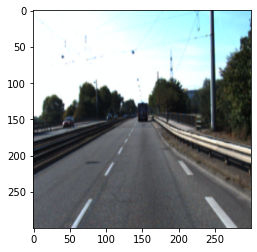

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs= next(iter(test_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)


In [ ]:
def original_dims(xy):

  x1 = xy[..., 0:1]/306
  y1 = xy[..., 1:2]/185
  x2 = xy[..., 2:3]/306
  y2 = xy[..., 3:4]/185

  return torch.cat([x1, y1, x2, y2], 1)


def bring_back_old_dimension(xy):
  x1 = xy[..., 0:1]*306
  y1 = xy[..., 1:2]*185
  x2 = xy[..., 2:3]*306
  y2 = xy[..., 3:4]*185

  return np.concatenate([x1, y1, x2, y2])

  

Generating predictions and detecting objects in test data

In [ ]:
model.eval()

#creating list to predictions and ground truth
model_pred_boxes = list()
model_pred_labels = list()
model_pred_scores = list()

with torch.no_grad():

    for images in test_loader:
      if train_on_gpu:
        images = images.to(device)
        

        nan_predicted_boxes, nan_predicted_class_scores = model(images)

       

        pred_box_per_batch, pred_labels_per_batch, pred_scores_per_batch = model.detect_objects(nan_predicted_boxes, nan_predicted_class_scores, min_score=0.4, max_overlap=0.7, top_k=4)
        #pred_box_per_batch = torch.tensor(pred_box_per_batch, dtype=torch.float)
        #print(bring_back_old_dimension(pred_box_per_batch))
        #pred_box_per_batch = bring_back_old_dimension(pred_box_per_batch)
        '''print('prediction_box', pred_box_per_batch)
        print('prediction_labels', pred_labels_per_batch)
        print('pred_scores', pred_scores_per_batch)'''

        #simultaneously storing original boxes and labels per batch
        #pred_box_per_batch = pred_box_per_batch.to('cpu')
        

        model_pred_boxes.extend(pred_box_per_batch)
        model_pred_labels.extend(pred_labels_per_batch)
        model_pred_scores.extend(pred_scores_per_batch) # lists of length batch_size
        #model_pred_boxes_cpu = np.array(model_pred_boxes).cpu()

        


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:166: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:168: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


Saving predictions

In [ ]:

np.save('complete_pred_boxes_test_loader_dhu', model_pred_boxes)
np.save('complete_pred_labels_test_loader_dhu', model_pred_labels)
np.save('complete_pred_scores_test_loader_dhu', model_pred_scores)


In [ ]:
nandhu_pred_boxes= np.load('/content/complete_pred_boxes_test_loader_dhu.npy', allow_pickle=True)
nandhu_pred_labels = np.load('/content/complete_pred_labels_test_loader_dhu.npy', allow_pickle=True)
nandhu_pred_scores = np.load('/content/complete_pred_scores_test_loader_dhu.npy',allow_pickle=True)

In [ ]:
nandhu_pred_boxes.cpu()

AttributeError: ignored

In [ ]:

boxes = bring_back_old_dimension(nandhu_pred_boxes)
print(boxes[1])

tensor([[ 56.3973, 134.4238,  65.1020, 153.7271],
        [ 56.5015, 133.8900,  65.2262, 153.5100],
        [ 55.1950, 134.7092,  63.0732, 153.2534],
        [ 55.0951, 135.2417,  62.9080, 153.5871]], device='cuda:0')


In [ ]:
print(nandhu_pred_scores[1])
print(nandhu_pred_labels[1])

tensor([0.9994, 0.9994, 0.9993, 0.9993], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')


In [ ]:
predictions = np.append(boxes, nandhu_pred_labels)
full_predictions = np.append(predictions, nandhu_pred_scores)
print(full_predictions[1])

tensor([[ 56.3973, 134.4238,  65.1020, 153.7271],
        [ 56.5015, 133.8900,  65.2262, 153.5100],
        [ 55.1950, 134.7092,  63.0732, 153.2534],
        [ 55.0951, 135.2417,  62.9080, 153.5871]], device='cuda:0')


In [ ]:
# Colormap for plotted bounding boxes 
cmap = {0: "r", "Pedestrian": "g", "Cyclist": "b", "Van": "yellow", "Truck": "black"}
#we deleted labels other than cars
print(len(cmap))
# Get boxes & classes for specific image
im_number = 250
new_boxes = ()
print(boxes)
#new_boxes = xy2yx(boxes=boxes)
#print(new_boxes)

classes = y_train[im_number]["classes"]
print(classes)
print(x_test.dtype)
# Plot image
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(x_test[im_number, ...])
ax.axis("off")
plt.title(f"Image {im_number}")

# Plot colored bounding boxes
for bbox, cls in zip(boxes, classes):
    try:
        cl = cmap[cls]
    except:
        cl = cmap['Misc']
    # Add rectangle (x,y), width, heigth
    height = bbox[2] - bbox[0]
    width = bbox[3] - bbox[1]
    rect = patches.Rectangle((bbox[1], bbox[0]), width, height, linewidth=1, edgecolor=cl, facecolor="none")
    ax.add_patch(rect)

In [ ]:
#the attached box numpy file need to be converted in boundary co-ordintes 

In [ ]:
#have to convert boxes into boundary co-ordinates

for i in range(len(SSD300_test_dataset)):

  new_tensor_box= torch.Tensor(nandhu_pred_boxes)


xy_pred_boxes = bring_back_old_dimension(new_tensor_box)
xy_pred_boxes = xy_pred_boxes.numpy()
  
  

